## Set up

Install required packages and load relevant data. Ensure you adjust to add relevant classifiers.

In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from joblib import dump
import pickle as pkl
import os
from imblearn.over_sampling import SMOTE 
## import required classifiers, preprocessing, etc.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
# Add additional as required

os.chdir(Path.cwd().parent)
# import custom files
from src.data import make_dataset
from src.data import submit_predictions
from src.visualization import visualize
#import misc visualisation and EDA packages
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns


In [2]:
os.chdir('notebooks')

### Set Directory paths

In [3]:
project_dir = Path.cwd().parent
report_dir = project_dir / 'reports'
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

## Download and Prepare Data

In [4]:
competition = 'uts-advdsi-nba-career-prediction'
make_dataset.download_data(competition=competition,
                           path=raw_data_dir,
                           unzip=True)

In [5]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')


In [6]:
X_test = pd.read_csv(raw_data_dir / 'test.csv')

In [7]:
df_train.drop(columns=['Id_old', 'Id'], inplace=True)
X_test.drop(columns=['Id_old'], inplace=True)
test_id = X_test.pop('Id')

## Split into Training and ValidationSet

In [8]:
target = 'TARGET_5Yrs'
X, y = make_dataset.separate_target(df_train, target=target)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

## Modelling

## Base Model
The base model is the model from week 1

In [9]:
file_name = models_dir /'brackenrig_mark_12964298_week1_votingclassifier.sav'
baseline_model = pkl.load(open(file_name,'rb'))

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[  18  245]
 [  18 1319]]
Accuracy:  0.835625
AUC:  0.7198313004257304
              precision    recall  f1-score   support

           0       0.50      0.07      0.12       263
           1       0.84      0.99      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.67      0.53      0.51      1600
weighted avg       0.79      0.84      0.78      1600



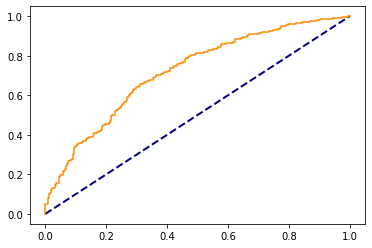

In [10]:
visualize.classification_reports(baseline_model,X_val,y_val)

# Include Oversampling
Including SMOTE with no calibration may improve results by oversampling the minority class

In [11]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)


In [12]:
model = baseline_model

model.fit(X_sm, y_sm)

Fitting 7 folds for each of 12 candidates, totalling 84 fits


RandomizedSearchCV(cv=7,
                   estimator=VotingClassifier(estimators=[('rf',
                                                           Pipeline(steps=[('classifier',
                                                                            RandomForestClassifier(oob_score=True))])),
                                                          ('lr',
                                                           Pipeline(steps=[('scaler',
                                                                            StandardScaler()),
                                                                           ('pca',
                                                                            PCA()),
                                                                           ('classifier',
                                                                            LogisticRegression(max_iter=10000))]))],
                                              voting='soft'),
                  

### Inspect Results

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[134 129]
 [345 992]]
Accuracy:  0.70375
AUC:  0.7016161828735237
              precision    recall  f1-score   support

           0       0.28      0.51      0.36       263
           1       0.88      0.74      0.81      1337

    accuracy                           0.70      1600
   macro avg       0.58      0.63      0.58      1600
weighted avg       0.79      0.70      0.73      1600



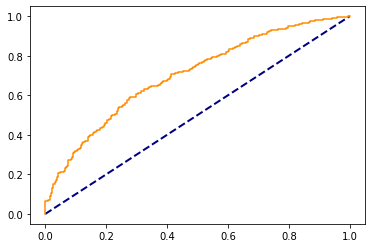

In [13]:
visualize.classification_reports(model,X_val,y_val)

Since it Didnt improve the results on the validation set, we will try to calibrate the model.


In [28]:
X_sm, y_sm = sm.fit_resample(X, y)
calibrated_model = CalibratedClassifierCV(model)

In [29]:
calibrated_model.fit(X_sm,y_sm)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
Fitting 7 folds for each of 12 candidates, totalling 84 fits
Fitting 7 folds for each of 12 candidates, totalling 84 fits
Fitting 7 folds for each of 12 candidates, totalling 84 fits
Fitting 7 folds for each of 12 candidates, totalling 84 fits


CalibratedClassifierCV(base_estimator=RandomizedSearchCV(cv=7,
                                                         estimator=VotingClassifier(estimators=[('rf',
                                                                                                 Pipeline(steps=[('classifier',
                                                                                                                  RandomForestClassifier(oob_score=True))])),
                                                                                                ('lr',
                                                                                                 Pipeline(steps=[('scaler',
                                                                                                                  StandardScaler()),
                                                                                                                 ('pca',
                                                                   

 class 1 :  6669
 class 0 :  1331
Confusion Matrix: 
 [[ 792  539]
 [1880 4789]]
Accuracy:  0.697625
AUC:  0.7225985555694123
              precision    recall  f1-score   support

           0       0.30      0.60      0.40      1331
           1       0.90      0.72      0.80      6669

    accuracy                           0.70      8000
   macro avg       0.60      0.66      0.60      8000
weighted avg       0.80      0.70      0.73      8000



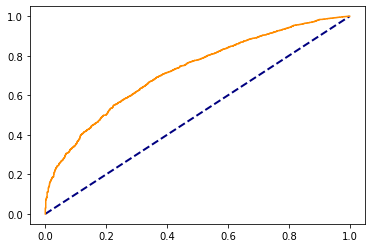

In [30]:
visualize.classification_reports(calibrated_model,X,y)

## Submit Predictions

In [31]:
submit_predictions.submit_predictions(calibrated_model, X_test, test_id,"SMOTE model experiment", pred_path=processed_data_dir/'12964298_week2_SMOTE.csv')

Success! User is Authenticated


100%|██████████| 88.2k/88.2k [00:05<00:00, 17.6kB/s]


,id,TARGET_5Yrs
0,0,0.609099
1,1,0.406272
2,2,0.839139
3,3,0.888420
4,4,0.302987
...,...,...
3794,3794,0.915986
3795,3795,0.591187
3796,3796,0.344923
3797,3797,0.897821
